# CNN Baseline: SelfMA + Toxigen (3-Class Classification)

Binary microaggression detection using CNN with:
- **Label 0**: Non-toxic (Toxigen, toxicity_human < 2)
- **Label 1**: Microaggressive (SelfMA)
- **Label 2**: Toxic (Toxigen, toxicity_human > 4)

## Pipeline:
1. Setup and load pre-balanced dataset
2. Text preprocessing and tokenization
3. CNN model training with GloVe embeddings
4. Evaluation and results

## 1. Setup

In [1]:
# Install dependencies
!pip install -q pandas numpy scikit-learn tensorflow gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 30.0 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import pandas as pd
import pickle
import datasets

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Conv1D,
                                     GlobalMaxPooling1D, Input, Concatenate,
                                     SpatialDropout1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
# GPU Configuration
print("=" * 60)
print("GPU/CPU Configuration")
print("=" * 60)

USE_GPU = True

def configure_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')

    print(f"Available devices:")
    print(f"  GPUs: {len(gpus)}")
    print(f"  CPUs: {len(cpus)}")

    if gpus and USE_GPU:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_visible_devices(gpus, 'GPU')
            print(f"\nGPU Configuration:")
            print(f"  Using GPU: {gpus[0].name}")
            print(f"  TensorFlow version: {tf.__version__}")
            return True
        except RuntimeError as e:
            print(f"GPU configuration failed: {e}")
            return False
    else:
        tf.config.set_visible_devices(cpus, 'CPU')
        print(f"\nUsing CPU")
        return False

GPU_AVAILABLE = configure_gpu()
print("=" * 60)

GPU/CPU Configuration
Available devices:
  GPUs: 1
  CPUs: 1

GPU Configuration:
  Using GPU: /physical_device:GPU:0
  TensorFlow version: 2.19.0


## 2. Load Pre-Balanced Dataset

In [4]:
# Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/266_project/balanced_selfMA_toxigen_ds"
print(f"Loading dataset from: {dataset_path}")

def load_data_split(base_path, split_name):
    split_path = f"{base_path}/{split_name}"
    print(f"  Loading {split_name}...")
    dataset = datasets.load_from_disk(split_path)
    df = dataset.to_pandas()

    # Standardize column names
    if 'text' in df.columns and 'cleaned_text' not in df.columns:
        df['cleaned_text'] = df['text']

    if 'label' in df.columns and 'target' not in df.columns:
        df['target'] = df['label']

    return df

# Load all splits
df_train = load_data_split(dataset_path, 'train')
df_val = load_data_split(dataset_path, 'validation')
df_test = load_data_split(dataset_path, 'test')

print(f"\nDataset loaded:")
print(f"  Train: {len(df_train)} samples")
print(f"  Validation: {len(df_val)} samples")
print(f"  Test: {len(df_test)} samples")

print(f"\nLabel distribution (train):")
print(df_train['target'].value_counts().sort_index())

Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/266_project/balanced_selfMA_toxigen_ds
  Loading train...
  Loading validation...
  Loading test...

Dataset loaded:
  Train: 3120 samples
  Validation: 390 samples
  Test: 390 samples

Label distribution (train):
target
0    1040
1    1040
2    1040
Name: count, dtype: int64


In [5]:
# Display sample data
print("Sample data from each class:")
for label in sorted(df_train['target'].unique()):
    print(f"\n--- Label {label} ---")
    samples = df_train[df_train['target'] == label].head(3)
    for idx, row in samples.iterrows():
        print(f"  {row['cleaned_text'][:100]}...")

Sample data from each class:

--- Label 0 ---
  there is no difference in the quality of parenting between gay and lesbian parents and heterosexual ...
  it's not just about being a model minority, but also about being a part of a diverse and multicultur...
  awesome...

--- Label 1 ---
  Just smile for me baby, let me see that pretty smile....
  I wish I was retarded. Then no one would expect anything of me, and I'd have lower expectations of m...
  You two boys can do this stretch against that wall....

--- Label 2 ---
  you can always tell when a person is of asian descent because of the shape of their eyes   ...
  i am not racist but mexicans are dirty and try to steal from me...
  youre just an arab keyboard warrior who is hiding behind a computer screen...


## 3. Text Preprocessing

In [6]:
# Calculate optimal sequence length
def calculate_sequence_length(texts, percentile=99):
    lengths = [len(str(text).split()) for text in texts]
    length_at_percentile = int(np.percentile(lengths, percentile))

    print(f"Text length statistics:")
    print(f"  Min: {min(lengths)}, Max: {max(lengths)}")
    print(f"  Mean: {np.mean(lengths):.2f}, Median: {np.median(lengths):.2f}")
    print(f"  {percentile}th percentile: {length_at_percentile}")

    return length_at_percentile, lengths

max_sequence_length, train_lengths = calculate_sequence_length(
    df_train['cleaned_text'].fillna(''), percentile=99
)
print(f"\nUsing max_sequence_length: {max_sequence_length}")

Text length statistics:
  Min: 1, Max: 416
  Mean: 17.05, Median: 16.00
  99th percentile: 43

Using max_sequence_length: 43


In [7]:
# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['target'])
y_val = label_encoder.transform(df_val['target'])
y_test = label_encoder.transform(df_test['target'])

print(f"\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

num_classes = len(label_encoder.classes_)
print(f"\nNumber of classes: {num_classes}")

Encoding labels...

Label mapping:
  0: 0
  1: 1
  2: 2

Number of classes: 3


In [8]:
# Tokenize text
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['cleaned_text'].fillna(''))

vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)
print(f"Vocabulary size: {vocab_size}")

# Convert to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['cleaned_text'].fillna('')),
                        maxlen=max_sequence_length, padding='post', truncating='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(df_val['cleaned_text'].fillna('')),
                      maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['cleaned_text'].fillna('')),
                       maxlen=max_sequence_length, padding='post', truncating='post')

print(f"\nPadded sequences shape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

Vocabulary size: 5206

Padded sequences shape:
  X_train: (3120, 43)
  X_val: (390, 43)
  X_test: (390, 43)


## 4. Load Pre-trained Embeddings (GloVe)

In [9]:
import urllib.request
import zipfile
import os

def load_glove_embeddings(embedding_dim=300):
    glove_path = f'glove.6B.{embedding_dim}d.txt'

    if not os.path.exists(glove_path):
        print(f"Downloading GloVe {embedding_dim}d embeddings...")
        urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('glove.6B.zip')

    print(f"Loading GloVe {embedding_dim}d...")
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors")

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hits, misses = 0, 0

    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            vec = embeddings_index.get(word)
            if vec is not None:
                embedding_matrix[i] = vec
                hits += 1
            else:
                misses += 1

    print(f"Coverage: {hits}/{hits+misses} ({100*hits/(hits+misses):.1f}%)")
    return embedding_matrix

EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings(EMBEDDING_DIM)
TRAINABLE_EMBEDDINGS = False

Loading GloVe 300d...
Found 400000 word vectors
Coverage: 4893/5205 (94.0%)


## 5. CNN Model

In [10]:
# Calculate class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights_array))

print("Class weights:")
for idx, weight in class_weight_dict.items():
    print(f"  Class {idx}: {weight:.4f}")

Class weights:
  Class 0: 1.0000
  Class 1: 1.0000
  Class 2: 1.0000


In [11]:
def create_cnn_model(vocab_size, embedding_dim, max_seq_length, num_classes,
                     embedding_matrix=None, trainable_embeddings=True):
    inputs = Input(shape=(max_seq_length,), dtype='int32')

    # Embedding layer
    if embedding_matrix is not None:
        x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_seq_length, trainable=trainable_embeddings)(inputs)
    else:
        x = Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(inputs)

    x = SpatialDropout1D(0.2)(x)

    # Parallel conv layers with different kernel sizes
    conv_blocks = []
    for kernel_size in [3, 4, 5]:
        conv = Conv1D(128, kernel_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    x = Concatenate()(conv_blocks)

    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
print("Creating CNN model...")
model = create_cnn_model(vocab_size, EMBEDDING_DIM, max_sequence_length, num_classes,
                         embedding_matrix, TRAINABLE_EMBEDDINGS)
model.summary()

Creating CNN model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 43, 300)   │  1,561,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 43, 300)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 43, 128)   │    115,328 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 43, 128)   │    153,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 43, 128)   │    192,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,155,851 (8.22 MB)

 Trainable params: 593,539 (2.26 MB)

 Non-trainable params: 1,562,312 (5.96 MB)

## 6. Training

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_cnn_toxigen.keras', monitor='val_loss', save_best_only=True, verbose=1)

print("Training CNN model...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

Training CNN model...
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4877 - loss: 1.0799
Epoch 1: val_loss improved from inf to 0.77909, saving model to best_cnn_toxigen.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.4884 - loss: 1.0788 - val_accuracy: 0.6026 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 2/30
89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7000 - loss: 0.7055
Epoch 2: val_loss improved from 0.77909 to 0.67235, saving model to best_cnn_toxigen.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7012 - loss: 0.7014 - val_accuracy: 0.7385 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 3/30
89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8092 - loss: 0.4944
Epoch 3: val_loss did not improve from 0.67235
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8079 - loss: 0.4960 - val_accuracy: 0.6231 - val_loss: 0.9989 - learning_rate: 0.0010
Epoch 4/30
89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8707 - loss: 0.33

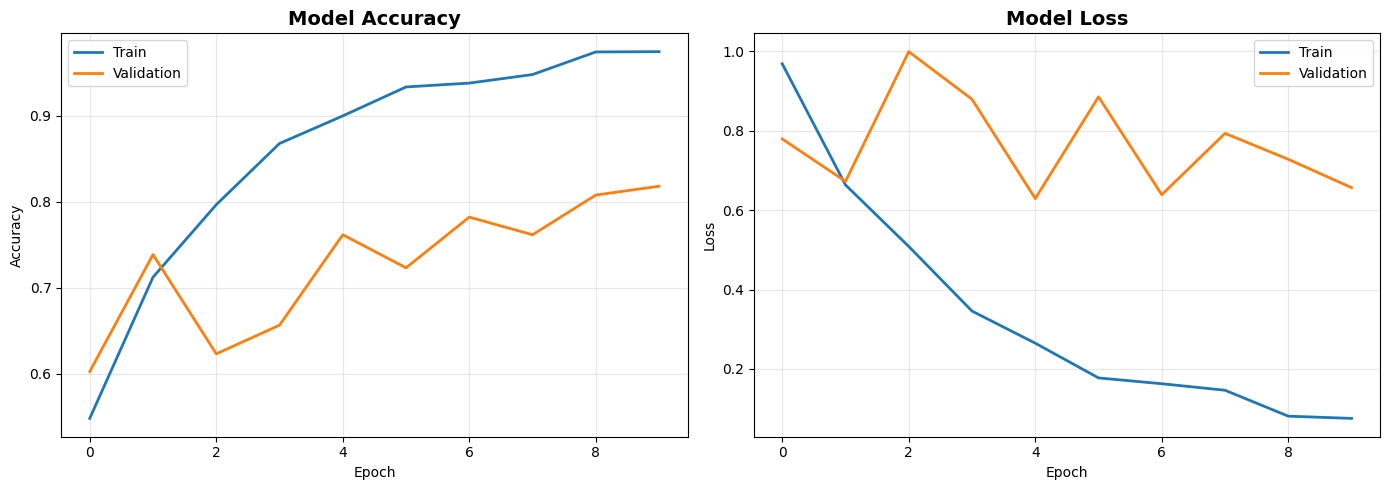

In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_toxigen.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Evaluation

In [14]:
# Evaluate on test set
print("Evaluating on test set...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred_classes,
                            target_names=['Non-toxic (0)', 'Microaggressive (1)', 'Toxic (2)']))

# Metrics summary
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"\nSummary Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

Evaluating on test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

      Non-toxic (0)       0.72      0.71      0.71       130
Microaggressive (1)       0.62      0.93      0.75       130
          Toxic (2)       0.81      0.42      0.56       130

           accuracy                           0.69       390
          macro avg       0.72      0.69      0.67       390
       weighted avg       0.72      0.69      0.67       390


Summary Metrics:
  Accuracy:  0.6872
  Precision: 0.7171
  Recall:    0.6872
  F1-Score:  0.6719


## 8. Cross-Dataset Evaluation: workplaceMA

Evaluate the trained model on an external benchmark dataset to assess generalization.

In [17]:
# Load workplaceMA dataset
print("Loading workplaceMA dataset...")
workplace_url = "https://huggingface.co/spaces/khanak27/microaggressionsdetector/resolve/main/micro_agg.csv"
df_workplace = pd.read_csv(workplace_url, encoding='latin-1')

# Standardize column names
df_workplace['cleaned_text'] = df_workplace['speech']
df_workplace['target'] = df_workplace['label']

print(f"workplaceMA loaded: {len(df_workplace)} samples")
print(f"\nLabel distribution:")
print(df_workplace['target'].value_counts().sort_index())

print(f"\nSample data:")
for label in sorted(df_workplace['target'].unique()):
    sample = df_workplace[df_workplace['target'] == label].iloc[0]
    print(f"  Label {label}: {sample['cleaned_text'][:80]}...")


Loading workplaceMA dataset...
workplaceMA loaded: 171 samples

Label distribution:
target
0    87
1    84
Name: count, dtype: int64

Sample data:
  Label 0: Feel free to suggest any edits....
  Label 1: You're very articulate for someone like you....


In [18]:
# Preprocess workplaceMA using the same tokenizer
print("Preprocessing workplaceMA...")

X_workplace = pad_sequences(
    tokenizer.texts_to_sequences(df_workplace['cleaned_text'].fillna('')),
    maxlen=max_sequence_length, padding='post', truncating='post'
)

# workplaceMA is binary (0=non-micro, 1=micro)
# Our model has 3 classes (0=non-toxic, 1=micro, 2=toxic)
# For evaluation, we'll map predictions:
#   - Model predicts 0 (non-toxic) -> Binary 0 (non-micro)
#   - Model predicts 1 (micro) -> Binary 1 (micro)
#   - Model predicts 2 (toxic) -> Binary 1 (micro) - toxic is also offensive

y_workplace = df_workplace['target'].values

print(f"X_workplace shape: {X_workplace.shape}")
print(f"y_workplace shape: {y_workplace.shape}")

Preprocessing workplaceMA...
X_workplace shape: (171, 43)
y_workplace shape: (171,)


In [19]:
# Evaluate on workplaceMA
print("Evaluating on workplaceMA...")
y_workplace_pred_proba = model.predict(X_workplace)
y_workplace_pred_3class = np.argmax(y_workplace_pred_proba, axis=1)

# Convert 3-class predictions to binary:
# 0 (non-toxic) -> 0 (non-micro)
# 1 (micro) or 2 (toxic) -> 1 (micro/offensive)
y_workplace_pred_binary = np.where(y_workplace_pred_3class == 0, 0, 1)

print("\n" + "=" * 60)
print("CROSS-DATASET EVALUATION: workplaceMA")
print("=" * 60)

print("\n--- Binary Classification (mapped from 3-class) ---")
print(classification_report(y_workplace, y_workplace_pred_binary,
                            target_names=['Non-Micro (0)', 'Microaggressive (1)']))

# Binary metrics
wp_accuracy = accuracy_score(y_workplace, y_workplace_pred_binary)
wp_precision = precision_score(y_workplace, y_workplace_pred_binary, average='weighted')
wp_recall = recall_score(y_workplace, y_workplace_pred_binary, average='weighted')
wp_f1 = f1_score(y_workplace, y_workplace_pred_binary, average='weighted')

print(f"Summary Metrics (Binary):")
print(f"  Accuracy:  {wp_accuracy:.4f}")
print(f"  Precision: {wp_precision:.4f}")
print(f"  Recall:    {wp_recall:.4f}")
print(f"  F1-Score:  {wp_f1:.4f}")


Evaluating on workplaceMA...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

CROSS-DATASET EVALUATION: workplaceMA

--- Binary Classification (mapped from 3-class) ---
                     precision    recall  f1-score   support

      Non-Micro (0)       0.78      0.21      0.33        87
Microaggressive (1)       0.53      0.94      0.68        84

           accuracy                           0.57       171
          macro avg       0.66      0.57      0.50       171
       weighted avg       0.66      0.57      0.50       171

Summary Metrics (Binary):
  Accuracy:  0.5673
  Precision: 0.6604
  Recall:    0.5673
  F1-Score:  0.5011



3-Class Prediction Distribution on workplaceMA:
Pred_3class   0    1  All
Actual                   
0            18   69   87
1             5   79   84
All          23  148  171


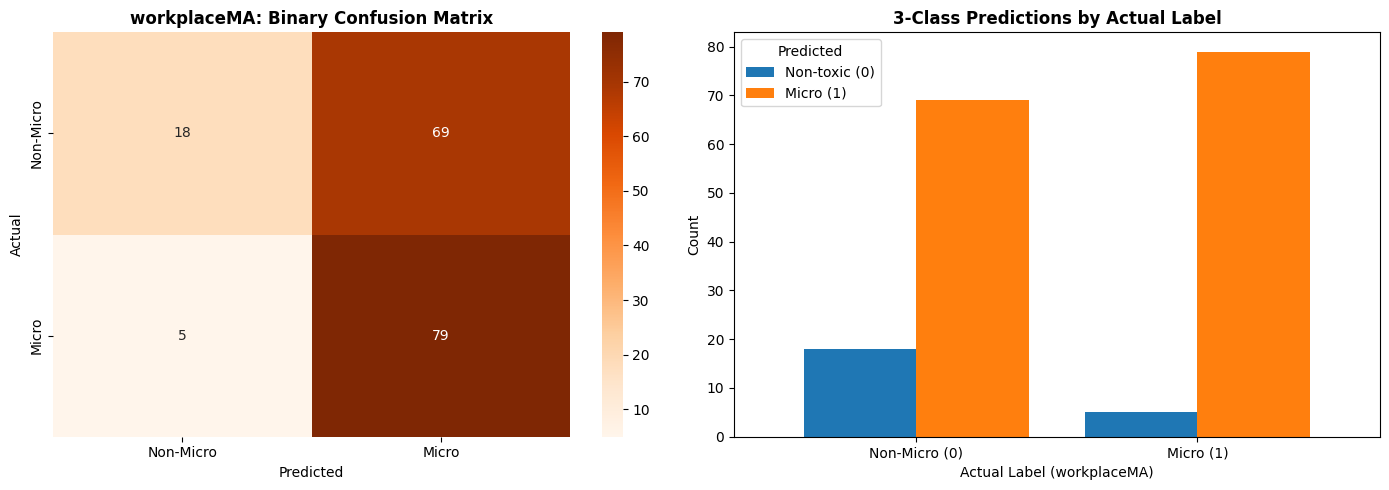

In [20]:
# Confusion Matrix for workplaceMA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary confusion matrix
cm_binary = confusion_matrix(y_workplace, y_workplace_pred_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Non-Micro', 'Micro'],
            yticklabels=['Non-Micro', 'Micro'])
axes[0].set_title('workplaceMA: Binary Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Show 3-class prediction distribution on binary ground truth
cm_3class = confusion_matrix(y_workplace, y_workplace_pred_3class, labels=[0, 1, 2])
# Expand to show how binary labels map to 3-class predictions
pred_dist = pd.DataFrame({
    'Actual': y_workplace,
    'Pred_3class': y_workplace_pred_3class
})
cross_tab = pd.crosstab(pred_dist['Actual'], pred_dist['Pred_3class'], margins=True)
print("\n3-Class Prediction Distribution on workplaceMA:")
print(cross_tab)

# Distribution plot
pred_counts_by_actual = pred_dist.groupby(['Actual', 'Pred_3class']).size().unstack(fill_value=0)
pred_counts_by_actual.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('3-Class Predictions by Actual Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Actual Label (workplaceMA)')
axes[1].set_ylabel('Count')
axes[1].legend(title='Predicted', labels=['Non-toxic (0)', 'Micro (1)', 'Toxic (2)'])
axes[1].set_xticklabels(['Non-Micro (0)', 'Micro (1)'], rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix_workplace.png', dpi=300, bbox_inches='tight')
plt.show()


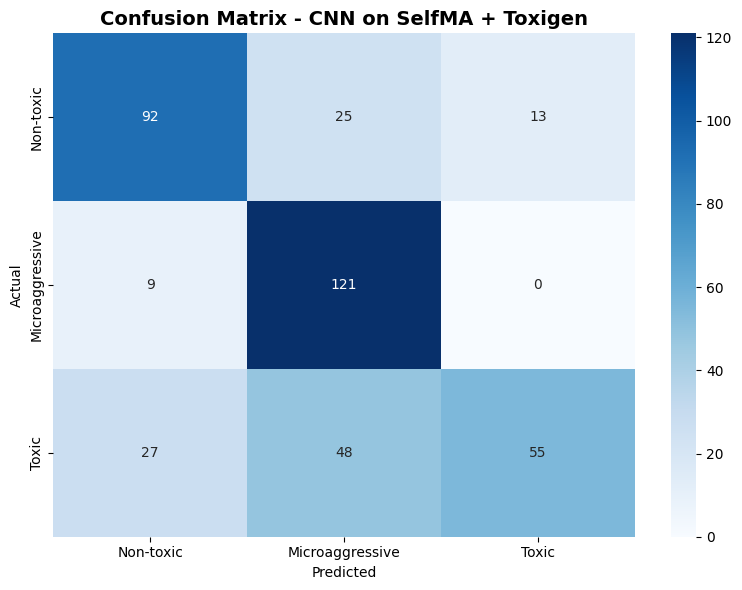

In [21]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-toxic', 'Microaggressive', 'Toxic'],
            yticklabels=['Non-toxic', 'Microaggressive', 'Toxic'])
plt.title('Confusion Matrix - CNN on SelfMA + Toxigen', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix_toxigen.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Results Summary

In [23]:
print("=" * 60)
print("CNN BASELINE RESULTS: SelfMA + Toxigen (3-Class)")
print("=" * 60)

print(f"""
Model Configuration:
--------------------
- Embedding: GloVe 300d (frozen)
- Architecture: Multi-kernel CNN (3, 4, 5)
- Dense layers: 256 -> 128
- Dropout: 0.3, 0.2

Training Dataset:
-----------------
- Train: {len(df_train)} samples
- Validation: {len(df_val)} samples
- Test: {len(df_test)} samples
- Classes: 3 (Non-toxic, Microaggressive, Toxic)

Test Set Results (SelfMA + Toxigen):
------------------------------------
- Accuracy:  {accuracy:.4f}
- Precision: {precision:.4f}
- Recall:    {recall:.4f}
- F1-Score:  {f1:.4f}

Cross-Dataset Evaluation (workplaceMA):
---------------------------------------
- Dataset size: {len(df_workplace)} samples
- Evaluation: Binary (3-class -> binary mapping)
- Accuracy:  {wp_accuracy:.4f}
- Precision: {wp_precision:.4f}
- Recall:    {wp_recall:.4f}
- F1-Score:  {wp_f1:.4f}
""")

CNN BASELINE RESULTS: SelfMA + Toxigen (3-Class)

Model Configuration:
--------------------
- Embedding: GloVe 300d (frozen)
- Architecture: Multi-kernel CNN (3, 4, 5)
- Dense layers: 256 -> 128
- Dropout: 0.3, 0.2

Training Dataset:
-----------------
- Train: 3120 samples
- Validation: 390 samples  
- Test: 390 samples
- Classes: 3 (Non-toxic, Microaggressive, Toxic)

Test Set Results (SelfMA + Toxigen):
------------------------------------
- Accuracy:  0.6872
- Precision: 0.7171
- Recall:    0.6872
- F1-Score:  0.6719

Cross-Dataset Evaluation (workplaceMA):
---------------------------------------
- Dataset size: 171 samples
- Evaluation: Binary (3-class -> binary mapping)
- Accuracy:  0.5673
- Precision: 0.6604
- Recall:    0.5673
- F1-Score:  0.5011

